# A minimal example of how to use Kruskal Test and analysis the Posh-hoc test result

In [1]:
%matplotlib inline

# Required imports
import pandas as pd
import matplotlib.pyplot as plt
from roses.statistical_test.kruskal_wallis import kruskal_wallis
from roses.effect_size import vargha_delaney

# For a beautiful plot
plt.style.use('ggplot')

# If you want let the plot beautiful
import seaborn as sns
sns.set_style("whitegrid")
sns.set(palette="pastel")

# Improving the readability in the plots
FONT_SIZE_PLOTS = 16
plt.rcParams.update({
    'font.size': FONT_SIZE_PLOTS,
    'xtick.labelsize': FONT_SIZE_PLOTS,
    'ytick.labelsize': FONT_SIZE_PLOTS,
    'legend.fontsize': FONT_SIZE_PLOTS,
    'axes.titlesize' : FONT_SIZE_PLOTS,
    'axes.labelsize' : FONT_SIZE_PLOTS
})

## Function to help the analysis

In [2]:
def print_mean(df):
    """
    This function group the data and presents for each algorithm the mean, std, max, and min values.
    Besides that, it returns the best algorithm based on the maximum mean value.
    """
    mean = df.groupby(['algorithm'], as_index=False).agg({'fitness': ['mean', 'std', 'max', 'min']})
    mean.columns = ['name', 'mean', 'std', 'max', 'min']
    
    # Round values (to be used in the article)
    mean = mean.round({'mean': 4, 'std': 3, 'max': 4, 'min': 4})
    mean = mean.infer_objects()

    bestalg = mean.loc[mean['mean'].idxmax()]

    return mean, bestalg['name']

## Read the Data

In [3]:
df = pd.read_csv('../resources/kruskal.csv', sep=";")
df

,algorithm,fitness
0,AlgorithmA,0.778856
1,AlgorithmD,0.730263
2,AlgorithmE,0.664486
3,AlgorithmB,0.742775
4,AlgorithmC,0.730346
...,...,...
145,AlgorithmA,0.780547
146,AlgorithmD,0.732662
147,AlgorithmE,0.671618
148,AlgorithmB,0.742228


## Apply the Kruskal-Wallis Test in the data

,Source,ddof1,H,p-unc
Kruskal,algorithm,4,135.951,2.076855e-28


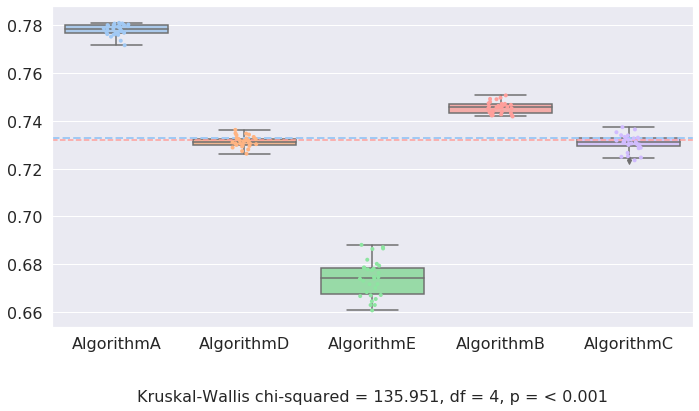

In [4]:
fig, ax = plt.subplots(figsize=(10,6))

k = kruskal_wallis(df, 'fitness', 'algorithm')
kruskal_result, posthoc = k.apply(ax)
plt.tight_layout()

kruskal_result

#plt.savefig("kruskal.pdf", bbox_inches='tight')
#plt.cla()
#plt.close(fig)

## Identifying the best algorithm

In [5]:
mean, best = print_mean(df)

print("Best algorithm:", best, "\n\nMeans:")

mean

Best algorithm: AlgorithmA 

Means:


,name,mean,std,max,min
0,AlgorithmA,0.7782,0.002,0.7810,0.7717
1,AlgorithmB,0.7455,0.002,0.7507,0.7419
2,AlgorithmC,0.7307,0.003,0.7374,0.7235
3,AlgorithmD,0.7313,0.002,0.7363,0.7263
4,AlgorithmE,0.6742,0.008,0.6881,0.6607


## Post-Hoc Tests

In [6]:
# post-hoc p-value results (if posthoc is not None)
print(posthoc[0])

           AlgorithmA AlgorithmB AlgorithmC AlgorithmD
AlgorithmB 0.05780    -          -          -         
AlgorithmC 1.0e-10    0.00035    -          -         
AlgorithmD 5.1e-10    0.00094    0.99930    -         
AlgorithmE 4.7e-14    7.6e-14    0.00094    0.00035   



In [7]:
# Get the posthoc and prepare the comparison against the best algorithm
df_eff = vargha_delaney.reduce(posthoc[1], best)

# Define symbols for each effect size magnitude
mean['eff_symbol'] = "$\\circ$"
mean['eff_symbol'] = mean.apply(lambda x: "$\\bigstar$" if x['name'] == best 
            else df_eff.loc[df_eff.compared_with==x['name'],'effect_size_symbol'].values[0], axis=1)

# Concat the values to a unique columns
mean['avg_std_effect'] = mean['mean'].map(str) + ' $\\pm$ ' + mean['std'].map(str) + " " + mean['eff_symbol'].map(str)

# Select the main information
mean = mean[['name', 'avg_std_effect']]

In [8]:
mean

,name,avg_std_effect
0,AlgorithmA,0.7782 $\pm$ 0.002 $\bigstar$
1,AlgorithmB,0.7455 $\pm$ 0.002 $\blacktriangle$
2,AlgorithmC,0.7307 $\pm$ 0.003 $\blacktriangle$
3,AlgorithmD,0.7313 $\pm$ 0.002 $\blacktriangle$
4,AlgorithmE,0.6742 $\pm$ 0.008 $\blacktriangle$


### Display the AVG +- STD EFFECT_SIZE and symbols for each effect size magnitude

In [9]:
mean_trans = mean.copy()
mean_trans.index = mean['name']
mean_trans = mean_trans.transpose()

temp_x = mean_trans.to_string(index=False, index_names=False).split("\n")[1:]
print(temp_x[0]) # Column names

# Just a beautiful print to use with LaTeX table :}
temp_split = temp_x[1].split()
cont = 1
for x in temp_split:
    print(f"{x} ", end="")
    if (cont % 4 == 0 and cont != len(temp_split)):
        print("& ", end="")
    cont += 1
print("\n\n")

                    AlgorithmA                           AlgorithmB                           AlgorithmC                           AlgorithmD                           AlgorithmE
0.7782 $\pm$ 0.002 $\bigstar$ & 0.7455 $\pm$ 0.002 $\blacktriangle$ & 0.7307 $\pm$ 0.003 $\blacktriangle$ & 0.7313 $\pm$ 0.002 $\blacktriangle$ & 0.6742 $\pm$ 0.008 $\blacktriangle$ 


